In [ ]:
# Employee_Turnover_Analytics_Project

In [1]:
pip install inflection


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install general_utils


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 29.3 MB/s eta 0:00:00


In [3]:
pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.3 MB/s eta 0:00:00


In [4]:
#importing all libraries

#For EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, randint, norm

# machine learning libraries
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# model evaluation and calibration
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, classification_report
from sklearn.model_selection import StratifiedKFold

# general utilities
import inflection
import pickle
#from general_utils import GeneralUtils


# preprocessing
from sklearn.preprocessing import MinMaxScaler

# feature selection
from boruta import BorutaPy


In [5]:
# creates a GeneralUtils object
#gu = GeneralUtils()

# sets seaborn default style
sns.set()


# sets matplolit inline
%matplotlib inline

# sets to display unlimited number of columns
pd.options.display.max_columns = 70

# sets the global seed
SEED = 42

# cramér V
def cramer_v(var_x, var_y):
    # builds contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values

    # gets the sum of all values in the matrix
    n = confusion_matrix.sum()

    # gets the rows, cols
    r, k = confusion_matrix.shape

    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix)[0]

    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)

    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))


def get_attribute_frequency(attribute):

    # creates a dictionary from value counts
    count_dict_attribute = attribute.value_counts().to_dict()

    # stores values as DataFrame
    df_count_attribute = pd.DataFrame(count_dict_attribute.items(), columns=['Value','Count'])

    # calculates the frequency for each value
    df_count_attribute['frequency'] = df_count_attribute['Count'] / df_count_attribute['Count'].sum()

    # gets a dictionary for the frequency
    frequency_attribute = df_count_attribute.set_index('Value').to_dict()['frequency']

    return frequency_attribute


def get_encoded_frequencies(data_frame):

    # creates an empty DataFrame
    encoded_freq = pd.DataFrame()

    # creates columns for frequency
    for column in data_frame.columns:
        encoded_freq[column] = data_frame[column].map(get_attribute_frequency(data_frame[column]))

    return encoded_freq

In [6]:
# loads data set

import pandas as pd
df_employee = pd.read_excel("/content/data.xlsx")

In [7]:
df_employee.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [8]:
#Shape of Data

df_employee.shape

(14999, 10)

In [9]:
#Information about Data

df_employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [10]:
# counts the number of each dtype

df_employee.dtypes.value_counts()

int64      6
float64    2
object     2
dtype: int64

In [11]:
# Checking for Null Values

df_employee.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [12]:
# creates a dataset for numerical attributes

num_attributes = df_employee.select_dtypes(include=['int64'])

# creates a dataset for categorical attributes

cat_attributes = df_employee.select_dtypes(exclude=['int64'])

In [13]:
# central tendency: mean, median

import numpy as np
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# distribution: std, min, max, range, skew, kurtosis

std = pd.DataFrame(num_attributes.apply(np.std)).T
min_value = pd.DataFrame(num_attributes.apply(min)).T
max_value = pd.DataFrame(num_attributes.apply(max)).T
range_value = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skewness = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# joining

summary_stats = pd.concat([min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
summary_stats.columns = ['attributes','min','max','range','mean','median','std','skewness','kurtosis']

In [14]:
summary_stats

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,number_project,2.0,7.0,5.0,3.803054,4.0,1.232551,0.337706,-0.495478
1,average_montly_hours,96.0,310.0,214.0,201.050337,200.0,49.941434,0.052842,-1.134982
2,time_spend_company,2.0,10.0,8.0,3.498233,3.0,1.460088,1.853319,4.773211
3,Work_accident,0.0,1.0,1.0,0.144610,0.0,0.351707,2.021149,2.085320
4,left,0.0,1.0,1.0,0.238083,0.0,0.425910,1.230043,-0.487060
5,promotion_last_5years,0.0,1.0,1.0,0.021268,0.0,0.144277,6.636968,42.054957


In [15]:
# checks how many types we have for each atribute in catagorical type

cat_attributes.apply(lambda x: x.unique().shape[0])

satisfaction_level    92
last_evaluation       65
sales                 10
salary                 3
dtype: int64

[]

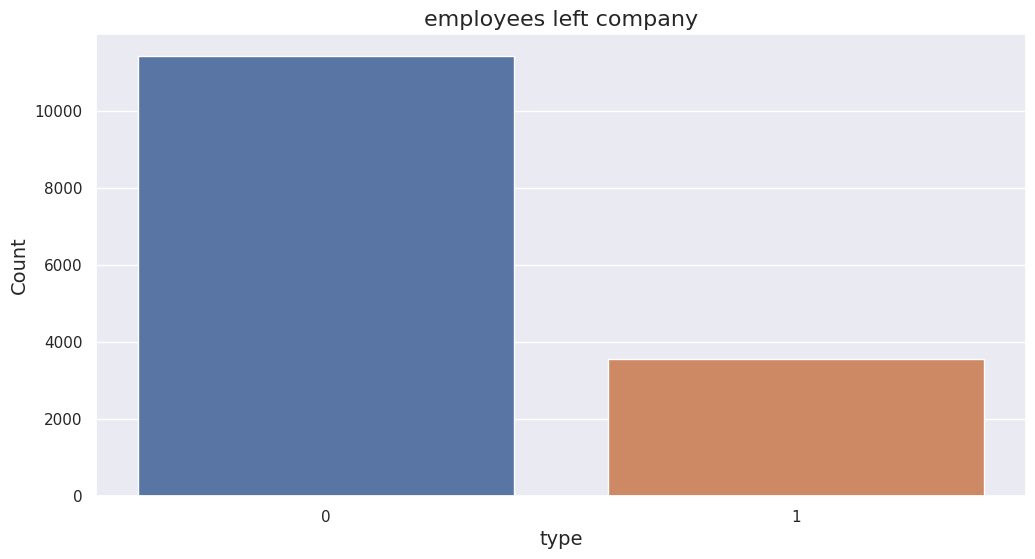

In [16]:
#Univariate analysis using target variable
# plots count
import matplotlib.pyplot as plt
ax = sns.countplot(x=df_employee['left'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# set plot features
ax.set_title("employees left company", fontsize=16)
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel("type", fontsize=14)

# displays plot
plt.plot()

In [17]:
# separating the data set for easier analysis
df_left = df_employee[df_employee['left'] == 1]
df_stayed = df_employee[df_employee['left'] ==0]

# Count the number of employees who stayed and left
# It seems that we are dealing with an imbalanced dataset
total_employees_left = df_left.shape[0]
total_employees_stayed = df_stayed.shape[0]
total_employees = df_employee.shape[0]

print('Number of employees who left:', total_employees_left)
print('This is equivalent to {:.2f}% of the total employees'.format((total_employees_left/total_employees)*100))

print('\nNumber of employees who stayed:', total_employees_stayed)
print('This is equivalent to {:.2f}% of the total employees'.format((total_employees_stayed/total_employees)*100))

Number of employees who left: 3571
This is equivalent to 23.81% of the total employees

Number of employees who stayed: 11428
This is equivalent to 76.19% of the total employees


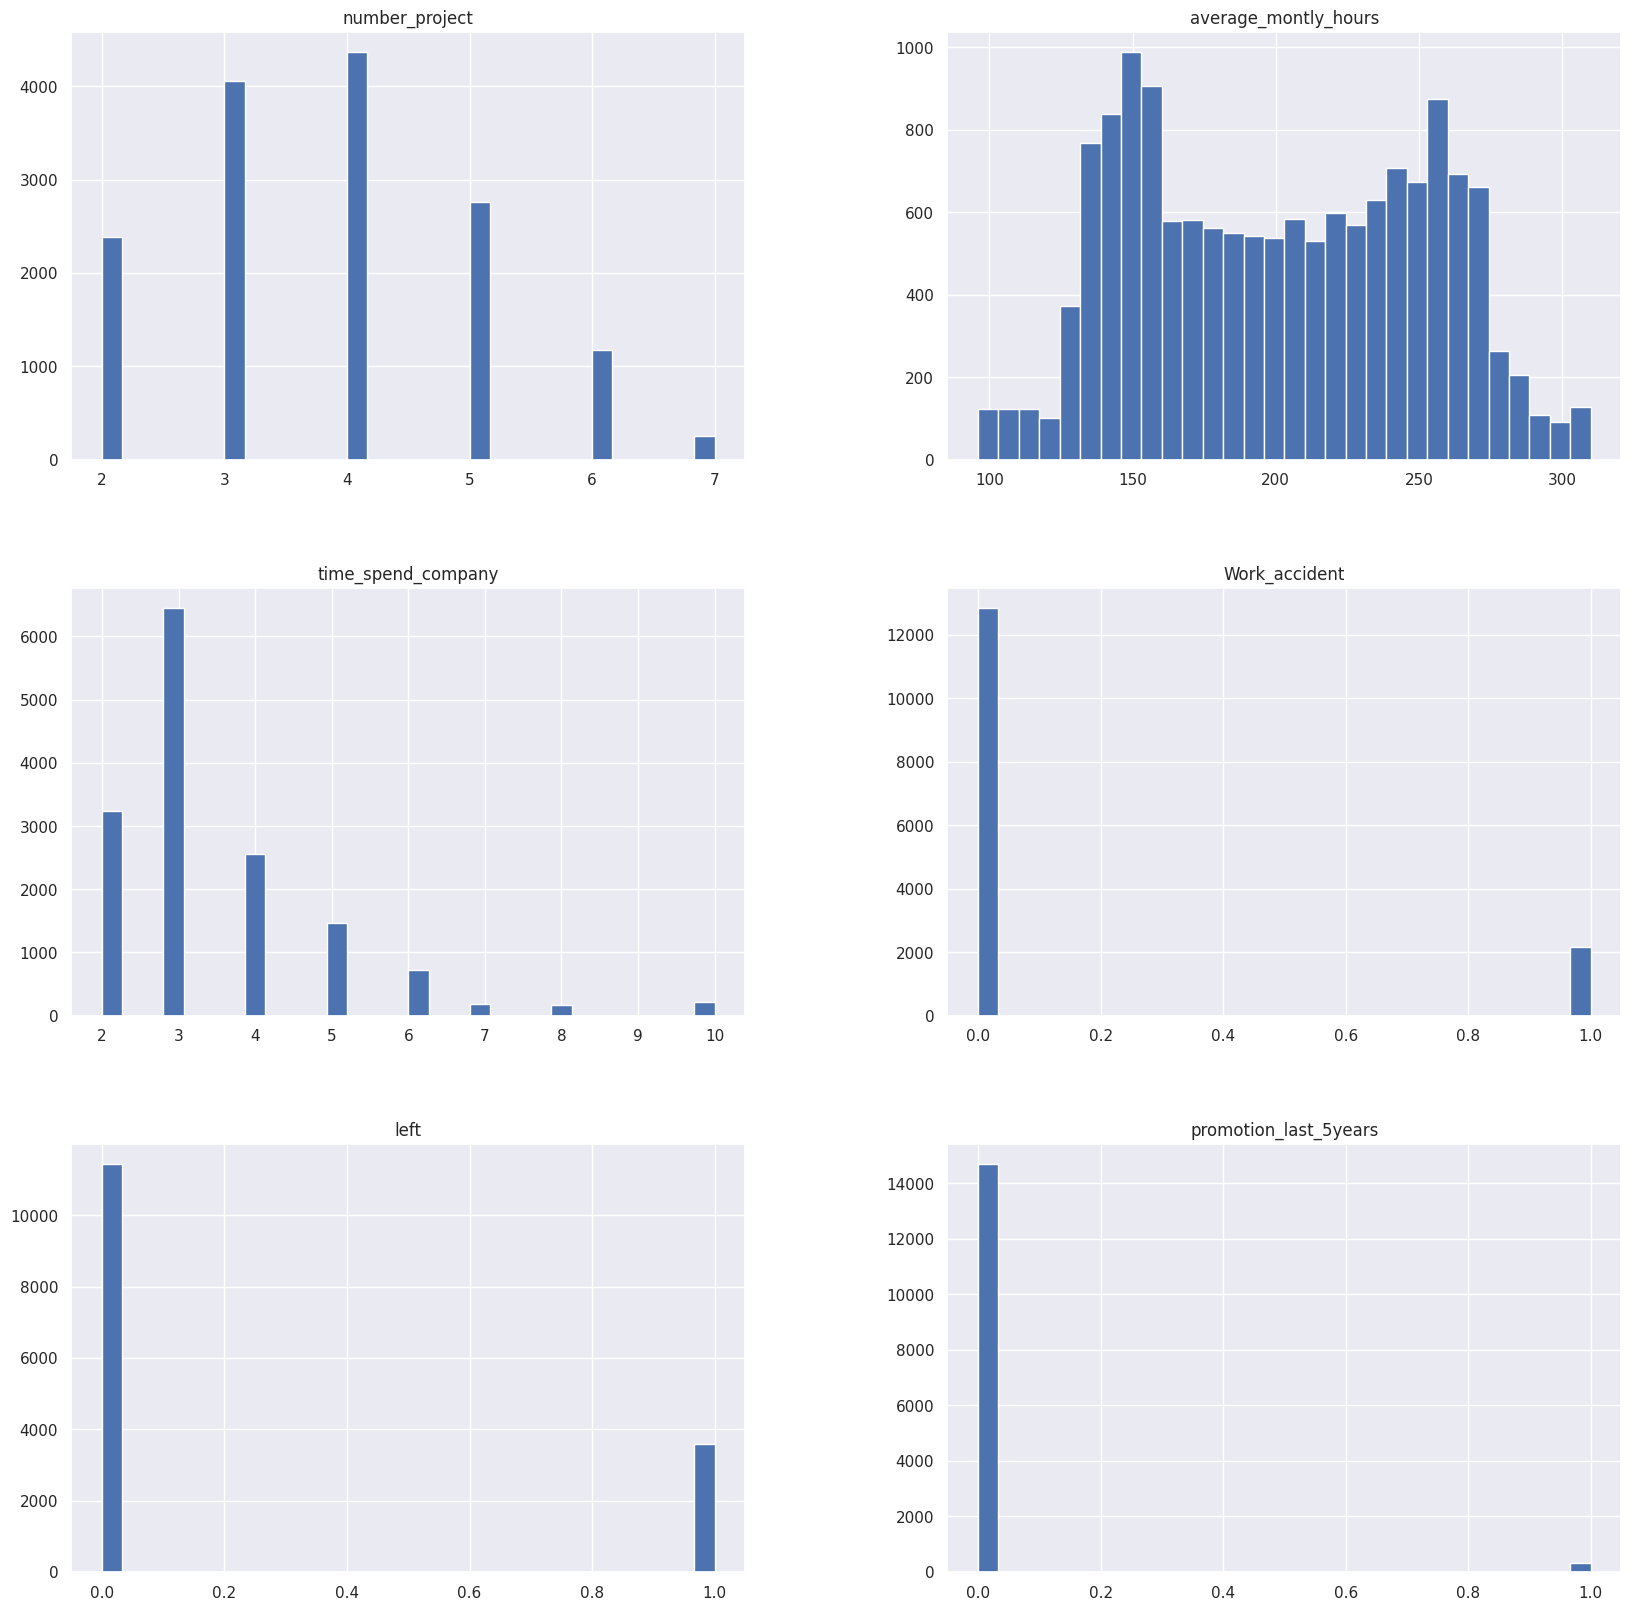

In [18]:
# plots a histogram for all numerical attributes

_ = num_attributes.hist(bins=30, figsize=(20,20))

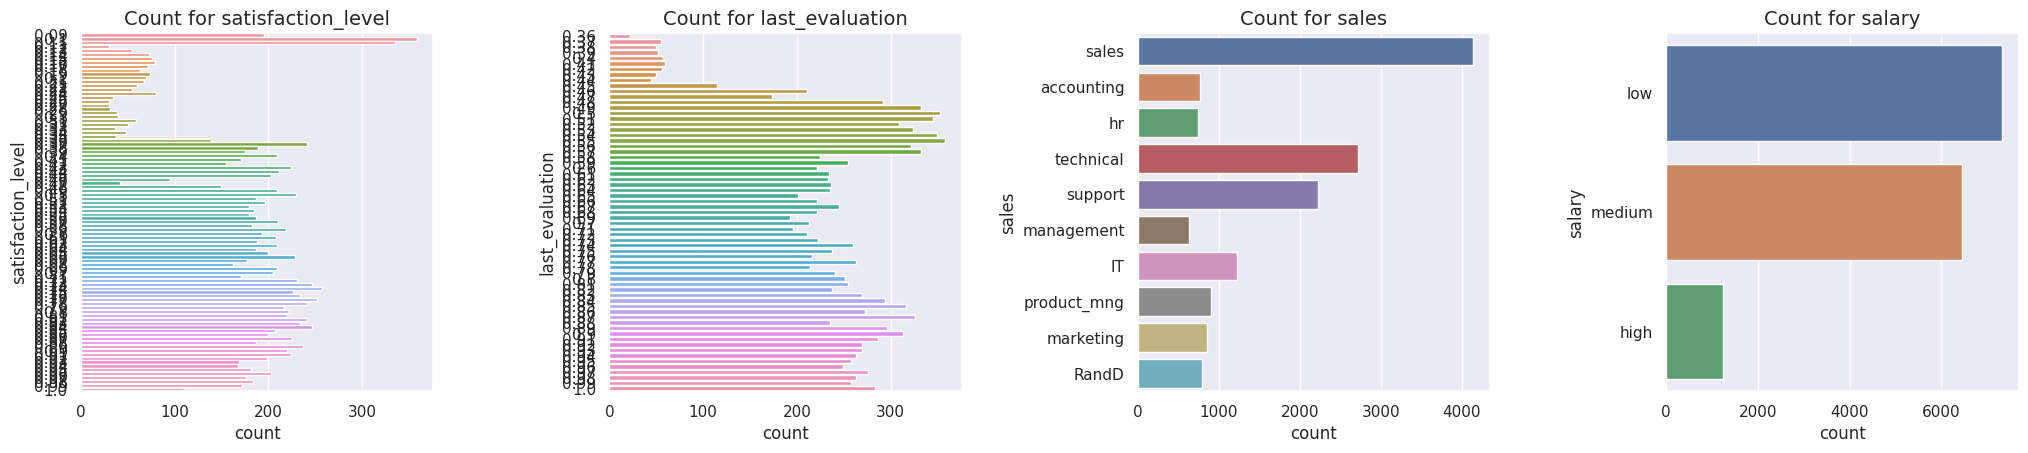

In [19]:
# Categorigal variables

# sets plot size
plt.figure(figsize=(25, 20))

# sets the inital plot position
n = 1

# iterates over the columns to plot
for column in cat_attributes.columns:
    plt.subplot(4, 4, n)
    _ = sns.countplot(y=cat_attributes[column])
    plt.title("Count for " + column, fontsize=14)
    n += 1

# adjust height and wdith reserved for space between subplots
plt.subplots_adjust(hspace=0.1)
plt.subplots_adjust(wspace=0.5)

# display the plot
plt.show()

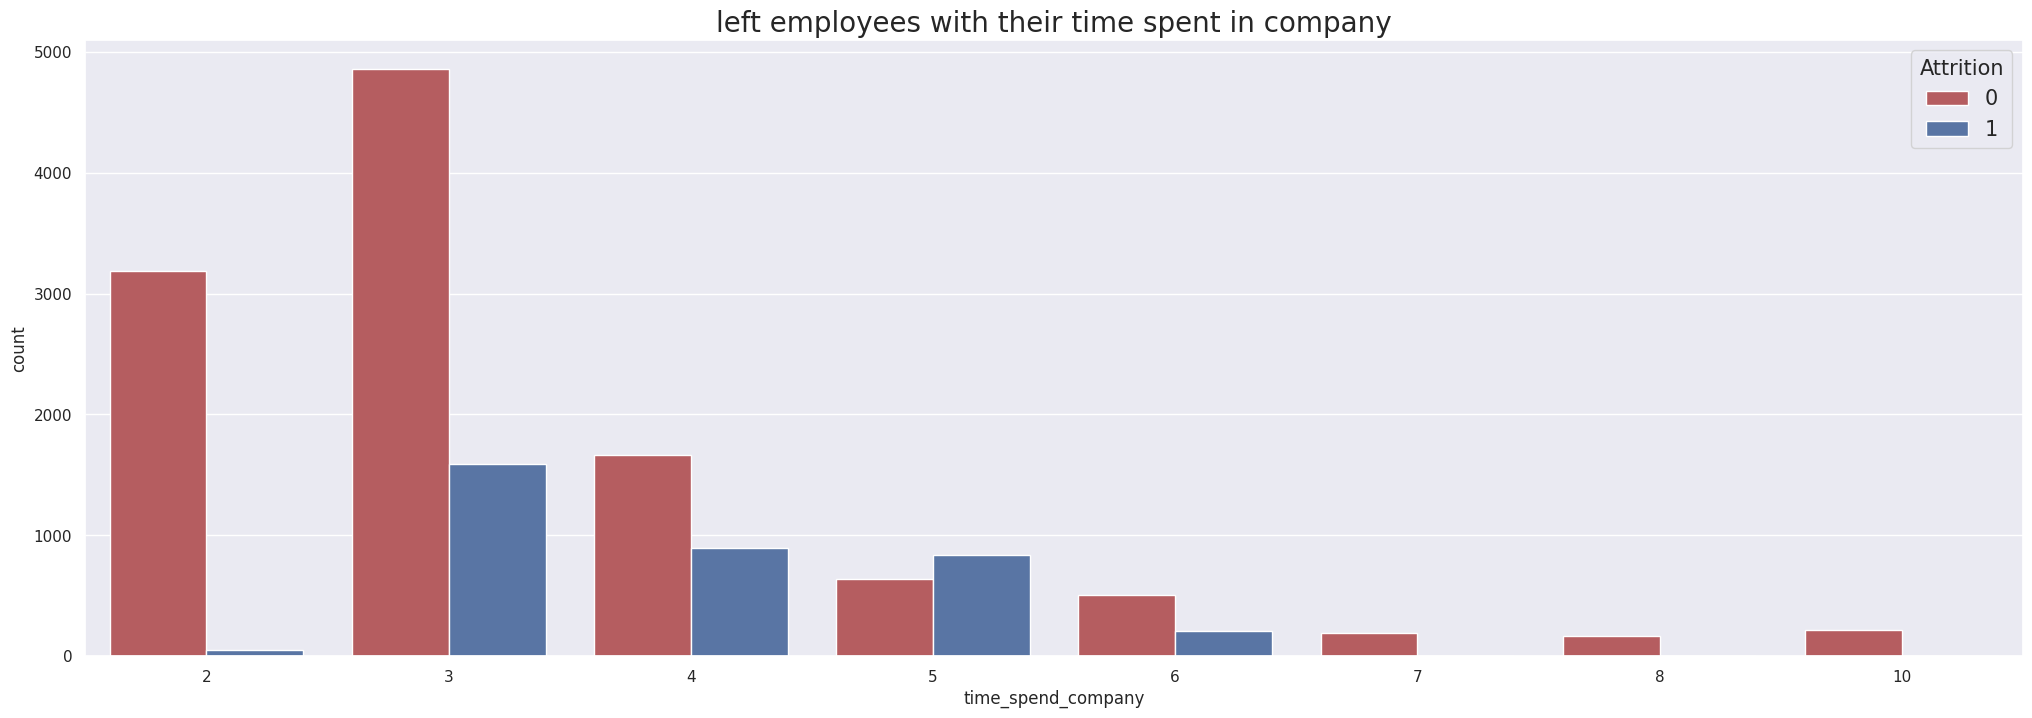

In [20]:
#ploting relation b/w left emplyees v/s they spent time

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='time_spend_company', hue='left', data=df_employee, palette=["r", "b"])

# sets plot title
ax.set_title("left employees with their time spent in company", fontsize=20)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

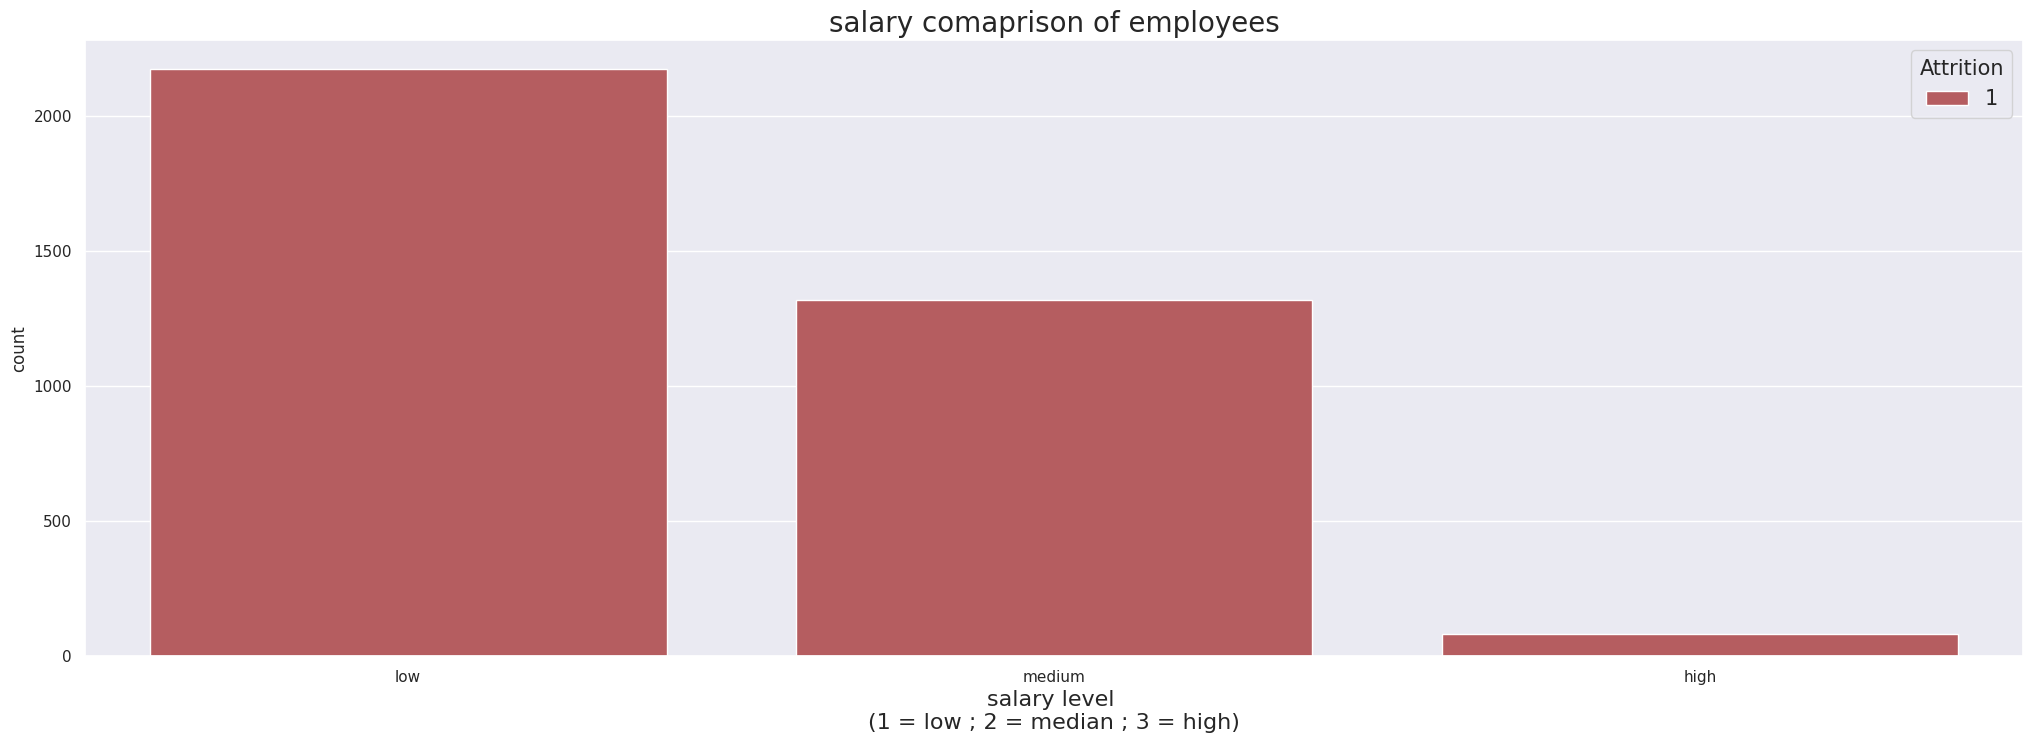

In [21]:
#ploting relation b/w left emplyees v/s their salary

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='salary', hue='left', data=df_left, palette=["r","b"])

# sets plot title
ax.set_title("salary comaprison of employees", fontsize=20)

# sets xlabel
plt.xlabel('salary level \n(1 = low ; 2 = median ; 3 = high)', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

<ipython-input-22-e584d77e3495>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_left['promotion_last_5years'], label='Employees who left', shade=True, color='r')
<ipython-input-22-e584d77e3495>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_stayed['promotion_last_5years'], label='Employees who stayed', shade=True, color='b')


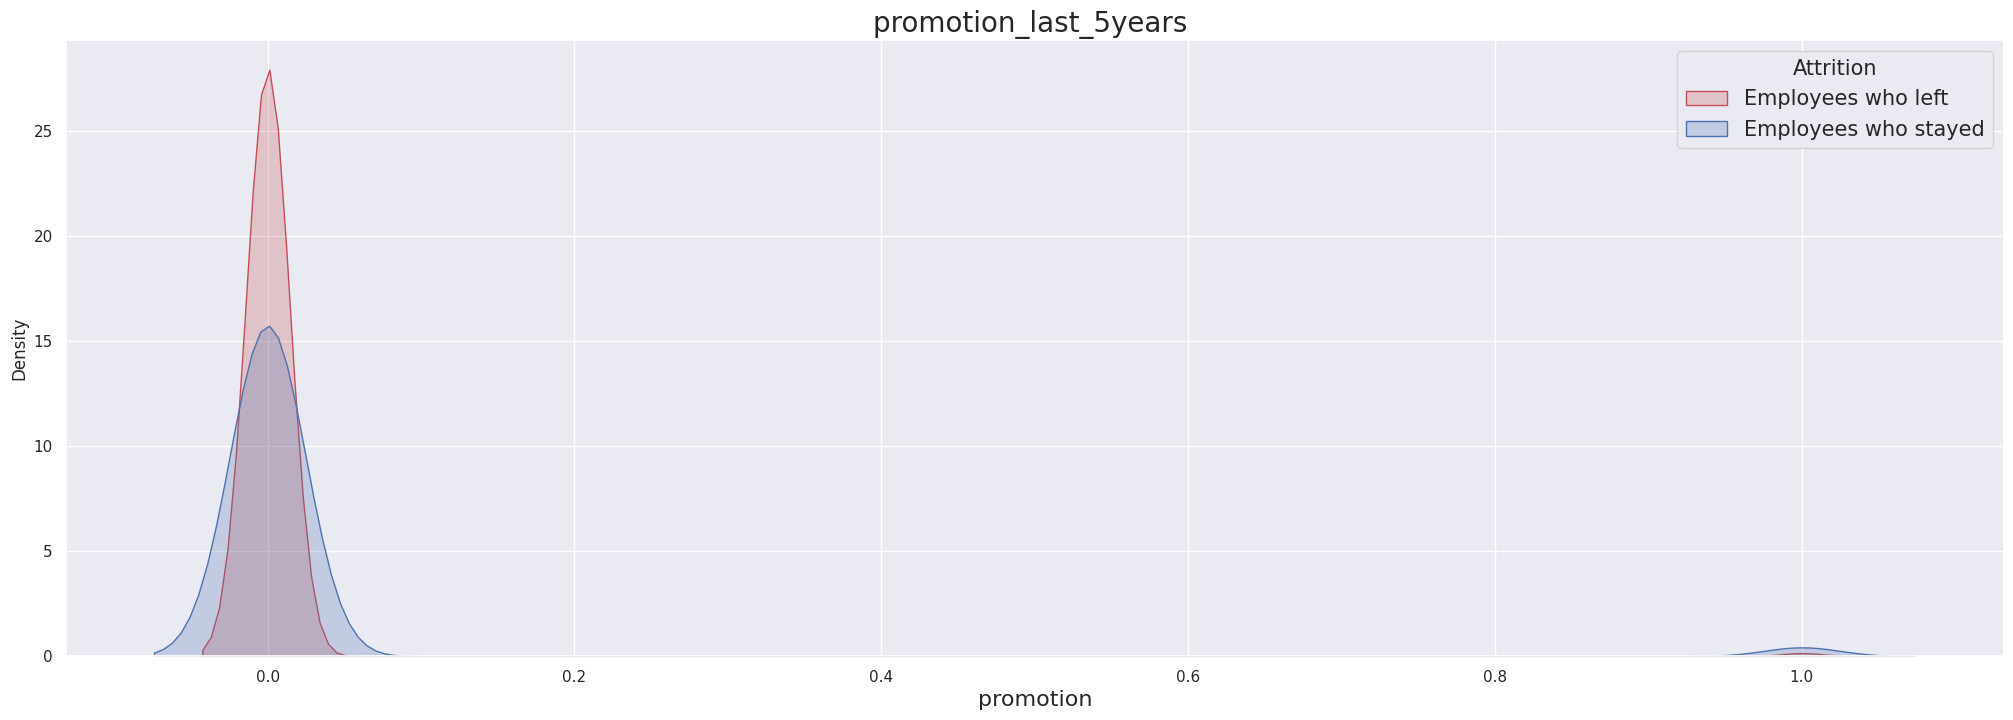

In [22]:
#ploting relation b/w left emplyees v/s their promotion in last 5 years

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# KDE (Kernel Density Estimate) is used for visualizing the Probability Density of continuos variable.
# KDE describes the probability density at different values in a continuous variable
sns.kdeplot(df_left['promotion_last_5years'], label='Employees who left', shade=True, color='r')
sns.kdeplot(df_stayed['promotion_last_5years'], label='Employees who stayed', shade=True, color='b')

# sets plot title
ax.set_title("promotion_last_5years ", fontsize=20)

# sets x label
plt.xlabel('promotion', fontsize=16)

# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# displays the plot
plt.show()

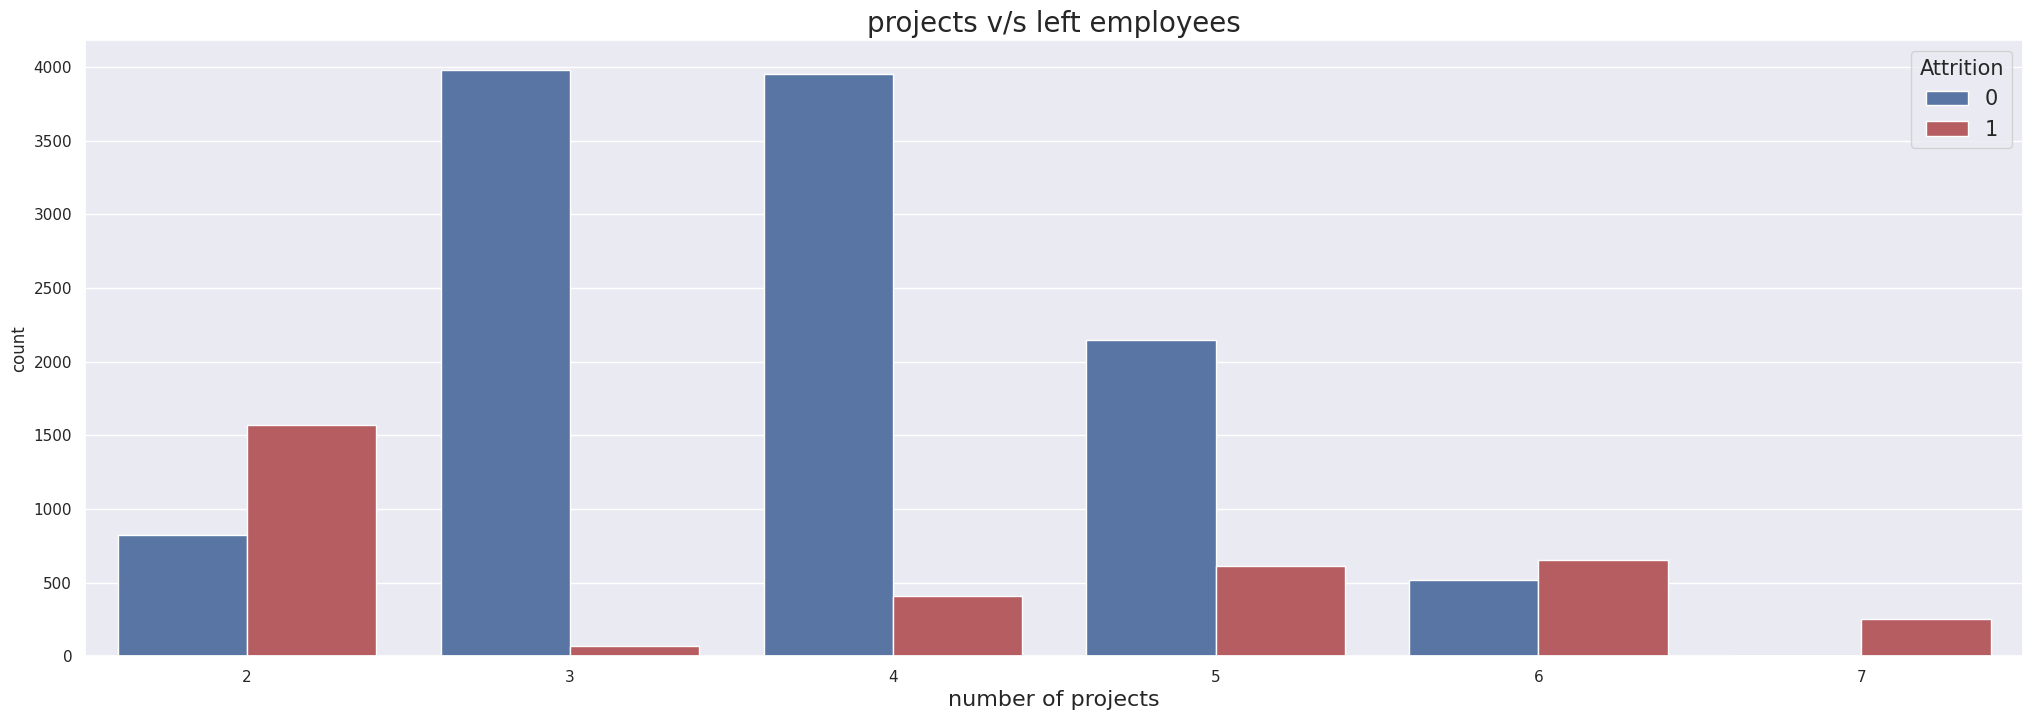

In [23]:
#ploting relation b/w left emplyees v/s projects they done

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 8)

# plots the graph
sns.countplot(x='number_project', hue='left', data=df_employee, palette=["b", "r"])

# sets plot title
ax.set_title("projects v/s left employees", fontsize=20)

# sets xlabel
plt.xlabel('number of projects', fontsize=16)



# sets the legend
plt.legend(title="Attrition", title_fontsize=15, fontsize=15)

# display plots
plt.show()

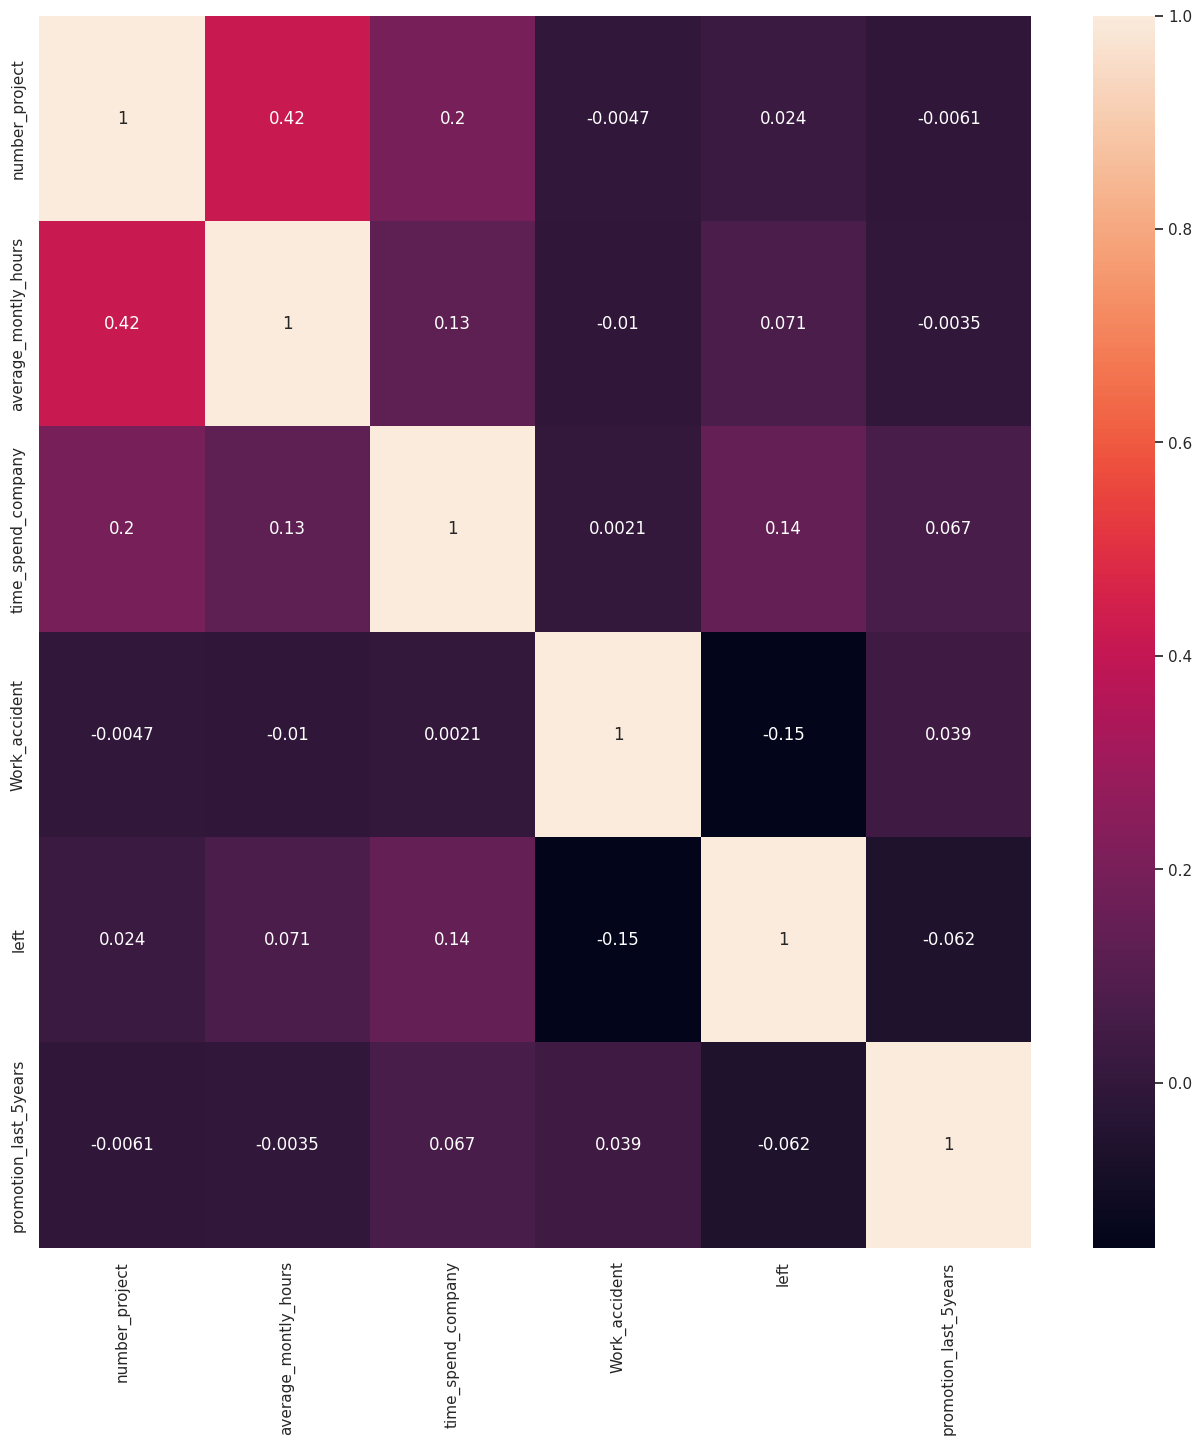

In [24]:
#co-relation b/w numerical variables

# gets the correlation between the numerical variables
correlation = num_attributes.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 16)

# plots the heatmap
sns.heatmap(correlation, annot=True)

# displays the plot
plt.show()

In [25]:
# instantiates the classes
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

In [26]:
scaled_numerical = mms.fit_transform(num_attributes)

In [27]:
# gets the Data Frame version of numerical scaled for later manipulation
df_scaled_numerical = pd.DataFrame(scaled_numerical)

# renaming the columns of result Data Frame
df_scaled_numerical.columns = num_attributes.columns

In [33]:
# define training test data for Boruta
X = df_employee.drop(['left','sales','salary'], axis=1).values
y = df_employee['left'].values.ravel()

In [34]:
# define RandomForestClassifier
# uses all cores from CPU
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs=-1)

In [35]:
# define Boruta
from boruta import BorutaPy
boruta = BorutaPy(rf_clf, n_estimators='auto', verbose=2, random_state=42).fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	2


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	2


In [38]:
# Assuming 'df_employee' is your DataFrame with 9 columns
# and 'cols_selected' is a boolean index of length 7 indicating the selected features

# Check the length of the boolean index
print(len(cols_selected))  # Output: 7

# Check the number of columns in the DataFrame
print(df_employee.shape[1])  # Output: 9

# Adjust the boolean index length to match the number of columns
cols_selected = cols_selected + [False, False]

# Verify the length of the boolean index again
print(len(cols_selected))  # Output: 9

# Get the column names of the selected features
selected_features = df_employee.drop('left', axis=1).iloc[:, cols_selected].columns.tolist()

# Print the selected feature names
print(selected_features)


7
10
9
['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']


In [39]:
# creates arrays for the features and target variable
SEED = 42
from sklearn.model_selection import train_test_split
X = df_employee.drop(['left','sales','salary'], axis=1).copy()
y = df_employee['left'].copy()

# splits into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [40]:
# counts the number of classes before oversampling

from collections import Counter
from imblearn.combine import SMOTETomek
counter = Counter(y_train)
print('Before balancing:', counter)


# defines the resampler
resampler = SMOTETomek(random_state=SEED, n_jobs=-1)

# transforms the data set
X_balanced, y_balanced = resampler.fit_resample(X_train, y_train)


# counts the number of classes after oversampling
counter = Counter(y_balanced)
print('After balancing:', counter)

Before balancing: Counter({0: 9142, 1: 2857})
After balancing: Counter({0: 9107, 1: 9107})


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create an empty list to store the performance results
performance_results = []

# Iterate over the classifiers
for classifier in classifiers:
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = classifier.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the performance results for the classifier
    performance_results.append({
        'Classifier': str(classifier),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

# Convert the performance results into a DataFrame
df_performance = pd.DataFrame(performance_results)

# Print the performance results
print(df_performance)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                                          Classifier  Accuracy  Precision  \
0                LogisticRegression(random_state=42)  0.770333   0.535613   
1            RandomForestClassifier(random_state=42)  0.990667   0.994236   
2  XGBClassifier(base_score=None, booster=None, c...  0.986000   0.980000   
3                    LGBMClassifier(random_state=42)  0.986333   0.986975   

     Recall  F1-score  
0  0.263305  0.353052  
1  0.966387  0.980114  
2  0.960784  0.970297  
3  0.955182  0.970819  


In [46]:
# highlight max values for each column
df_performance.style.highlight_max(color='darkorange')

,Classifier,Accuracy,Precision,Recall,F1-score
0,LogisticRegression(random_state=42),0.770333,0.535613,0.263305,0.353052
1,RandomForestClassifier(random_state=42),0.990667,0.994236,0.966387,0.980114
2,"XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, predictor=None, random_state=42, ...)",0.986000,0.980000,0.960784,0.970297
3,LGBMClassifier(random_state=42),0.986333,0.986975,0.955182,0.970819


In [47]:
# instantiates the classifiers
lr_clf = LogisticRegression(random_state=SEED)
lgbm_clf = LGBMClassifier(random_state=SEED, n_jobs=-1)

# trains the classifiers
lr_clf.fit(X_balanced, y_balanced)
lgbm_clf.fit(X_balanced, y_balanced)

# store the predicted probabilities for class 1
y_pred_lr_prob = lr_clf.predict_proba(X_test)[:, 1]
y_pred_lgbm_prob = lgbm_clf.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<ipython-input-48-53f17b59c017>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)


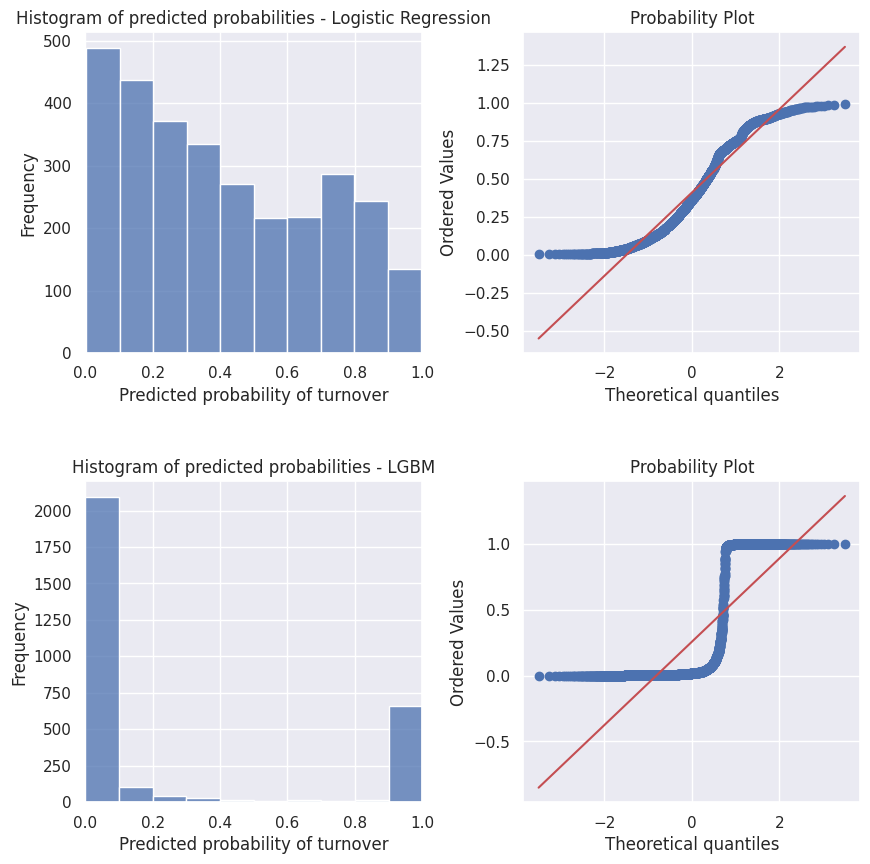

In [48]:
# set axes
fig, ax = plt.subplots()

# set fig size
ax.figure.set_size_inches(10, 10)

# plot histogram
plt.subplot(2, 2, 1)
ax = sns.histplot(y_pred_lr_prob, bins=10)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities - Logistic Regression')
plt.xlabel('Predicted probability of turnover')
plt.ylabel('Frequency')

# plot probability
plt.subplot(2, 2, 2)
ax = stats.probplot(y_pred_lr_prob, plot=plt)


# plot histogram
plt.subplot(2, 2, 3)
ax = sns.histplot(y_pred_lgbm_prob, bins=10)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities - LGBM')
plt.xlabel('Predicted probability of turnover')
plt.ylabel('Frequency')

# plot probability
plt.subplot(2, 2, 4)
ax = stats.probplot(y_pred_lgbm_prob, plot=plt)

plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.4)

# displays the plot
plt.show()

In [49]:
# makes predictions
y_pred_lr = lr_clf.predict(X_test)
y_pred_lgbm = lgbm_clf.predict(X_test)

print('Classification Report for ' + type(lr_clf).__name__)
print(classification_report(y_test, y_pred_lr))

print('\nClassification Report for ' + type(lgbm_clf).__name__)
print(classification_report(y_test, y_pred_lgbm))

Classification Report for LogisticRegression
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      2286
           1       0.49      0.75      0.59       714

    accuracy                           0.75      3000
   macro avg       0.70      0.75      0.71      3000
weighted avg       0.81      0.75      0.77      3000


Classification Report for LGBMClassifier
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.97      0.96      0.97       714

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [50]:
# instantiates classifier
lr_clf = LogisticRegression(random_state=SEED, n_jobs=-1)

In [51]:
# set up space dictionary with specified hyperparameters
space = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
         'solver': ['newton-cg', 'lbfgs', 'liblinear'],
         'penalty': ['l2', 'l1', 'elasticnet', None]}

In [52]:
# prepares RandomizedSearchCV object
lr_clf_cv = GridSearchCV(estimator=lr_clf, param_grid=space, scoring='recall', cv=10, verbose=2, n_jobs=-1)

In [53]:
# fits the RandomizedSearchCV object
lr_clf_cv.fit(X_balanced, y_balanced)

Fitting 10 folds for each of 84 candidates, totalling 840 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
420 fits failed out of a total of 840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Sol

GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l2', 'l1', 'elasticnet', None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='recall', verbose=2)

In [54]:
# best estimator
lr_clf_cv.best_estimator_

LogisticRegression(C=0.001, n_jobs=-1, penalty='l1', random_state=42,
                   solver='liblinear')

In [55]:
# Print the tuned parameters and score
print("\nTuned Parameters: {}".format(lr_clf_cv.best_params_))
print("\nBest score: {:.4f}".format(lr_clf_cv.best_score_))


Tuned Parameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}

Best score: 0.9795


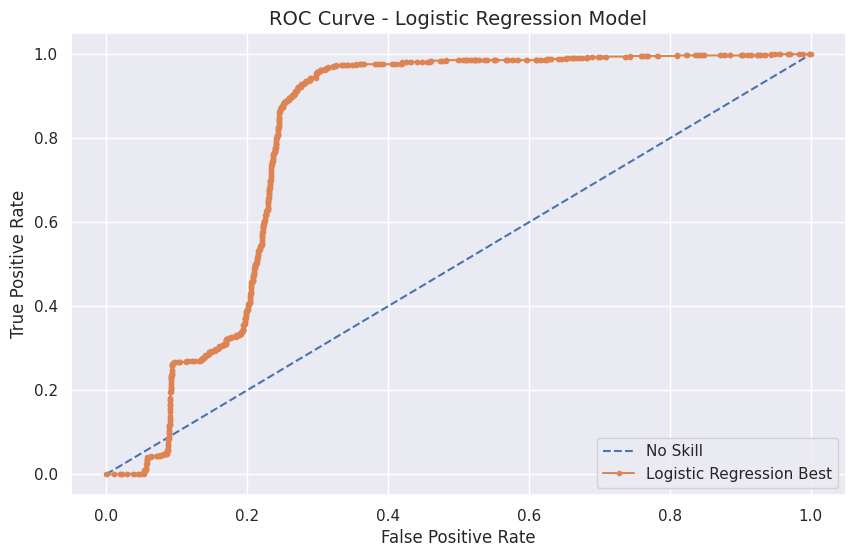

In [58]:
# sets the plot size
plt.figure(figsize=(10,6))

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
fpr, tpr, _ = roc_curve(y_test, lr_best_model_probs[:,1])

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic Regression Best')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# title
plt.title('ROC Curve - Logistic Regression Model', fontsize=14)

# show the legend
plt.legend()

# show the plot
plt.show()

In [59]:
print(f'Ratio of negatives in full data set: {y.value_counts(normalize=True).to_dict()[0]}')
print(f'Ratio of positives in full data set: {y.value_counts(normalize=True).to_dict()[1]}')

Ratio of negatives in full data set: 0.7619174611640777
Ratio of positives in full data set: 0.2380825388359224


In [60]:
# defines the cross validation strategy
cv = StratifiedKFold(n_splits=10)

In [61]:
# calculates the cross validation scores
cv_scores = cross_val_score(lr_best_model, X, np.ravel(y), cv = cv, scoring='precision', n_jobs=-1)

# prints the average accuracy and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

# calculates the cross validation scores
cv_scores = cross_val_score(lr_best_model, X, np.ravel(y), cv = cv, scoring='recall', n_jobs=-1)

# prints the average accuracy and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

# calculates the cross validation scores
cv_scores = cross_val_score(lr_best_model, X, np.ravel(y), cv = cv, scoring='roc_auc', n_jobs=-1)

# prints the average accuracy and standard deviation of the scores
print("\nAverage ROC AUC: %0.4f (+/- %0.4f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

Average precision: 0.0000 (+/- 0.0000)

Average recall: 0.0000 (+/- 0.0000)

Average ROC AUC: 0.4686 (+/- 0.0315)
